In [1]:
%matplotlib notebook

import json
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
BURN_IN = 20

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

In [3]:
with open('data.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}
    
for key in raw_data.keys():
    solver, params = key
    timeseries = raw_data[key][1]
            
    if solver == 'CBM':
        for species in ['P', 'RNA']:
            timeseries[species] = np.array(timeseries[species + 'nuc']) + np.array(timeseries[species + 'cyt'])
            del timeseries[species + 'nuc']
            del timeseries[species + 'cyt']
    
    del timeseries['Gf']
    del timeseries['Gb']
    
    for species in timeseries:
        timeseries[species] = np.array(timeseries[species])[:, BURN_IN:]

In [4]:
summary_statistics_raw = {
        'mean': lambda x: np.mean(x),
        'std': lambda x: np.std(x),
        'min': lambda x: np.min(x),
        'max': lambda x: np.max(x),
        }

stat_mean = {k + species: np.mean([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

stat_std = {k + species: np.std([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

summary_statistics = {
            k + species: lambda x: (s(x) - stat_mean[k + species])/stat_std[k + species]
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']
        }

lst_square = lambda x,y: (
        (np.array([summary_statistics[k + species](x[species])
                   for k in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']])
        - (np.array([summary_statistics[k + species](y[species])
                   for k in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']]))
    )**2).sum()**0.5

In [5]:
print(stat_mean)
print(stat_std)

{'meanP': 1042.154285695293, 'meanRNA': 61.844218439788314, 'stdP': 269.7571445476583, 'stdRNA': 15.925807595648152, 'minP': 242.33203125, 'minRNA': 11.462890625, 'maxP': 1731.669921875, 'maxRNA': 104.96223958333333}
{'meanP': 526.6189072354466, 'meanRNA': 11.768310207409813, 'stdP': 192.79740339753218, 'stdRNA': 6.933396613857465, 'minP': 342.49949120254036, 'minRNA': 15.636285190573679, 'maxP': 796.5365881305912, 'maxRNA': 4.996731346683865}


In [6]:
# Refactor data
data = {}
for k, v in raw_data.items():
    solver, params = k
    data.setdefault(params, {})[solver] = v

In [7]:
# SS and KG for CBM
ss_dist = {solver:
           {k:
              lst_square(v['smoldyn'][1], v[solver][1])
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['CBM', 'WMM']
          }

ks_dist = {solver :
           {k:
              sum([
                  scs.ks_2samp(v['smoldyn'][1][species].reshape(-1), v[solver][1][species].reshape(-1))[0]
                  for species in ['P', 'RNA']])/2
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['CBM', 'WMM']
          }

<IPython.core.display.Javascript object>


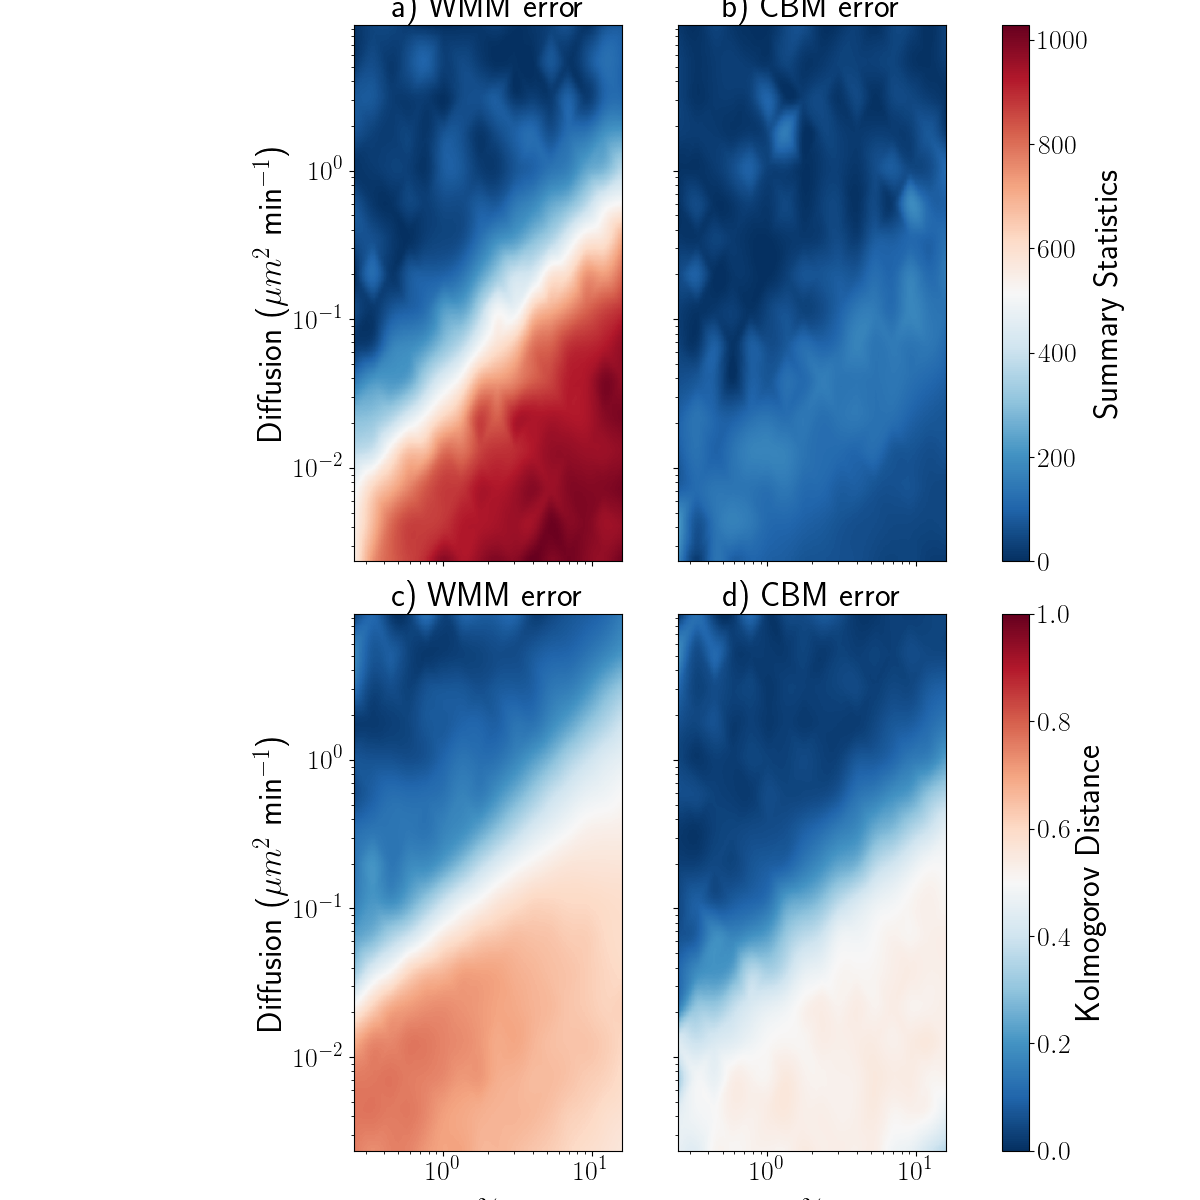

In [8]:
params = {'legend.fontsize': 20,
         'figure.figsize': (12, 12),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.tight_layout(w_pad=-24.0, h_pad=2)
for y in range(2):   
    dist = ks_dist if y else ss_dist
    max_dist = max(1, max(max(dist['CBM'].values()), max(dist['WMM'].values())))
    for x in range(2):
        solver = 'CBM' if x else 'WMM'
        dist_sol = dist[solver]

        min_x = log_value(min(dist_sol.keys(), key=lambda t: t[1])[1])
        max_x = log_value(max(dist_sol.keys(), key=lambda t: t[1])[1])
        min_D = log_value(min(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
        max_D = log_value(max(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')

        raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z]
                             for ((D, chi, k_d), z) in dist_sol.items()
                            if k_d == 0])

        XY = raw_grid[:, :2]
        Z = raw_grid[:, 2]

        xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
        grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='cubic')

        pcm = ax[y, x].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
                   origin='lower', vmin=0, vmax=max_dist, cmap='RdBu_r')

        if not x:
            ax[y, x].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')
        if y:
            ax[y, x].set_xlabel(r'$\chi$')

        ax[y, x].set_title(f"{chr(ord('a') + x + 2*y)}) {solver} error") # TODO specify dist in title


        xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
        ax[y, x].set_xticks(xticks)
        ax[y, x].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
        ax[y, x].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

        yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
        ax[y, x].set_yticks(yticks)
        ax[y, x].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
        ax[y, x].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    cb = fig.colorbar(pcm, ax=ax[y, :], location='right', shrink=1)
    cb.set_label('Kolmogorov Distance' if y else 'Summary Statistics')

fig.suptitle(fr"Comparison of the CBM and the WMM in the ($\chi$, D) plane",
             y=1.05, x=0.55)
plt.savefig("distChiD.pdf", bbox_inches='tight')
